Running 100 independent simulations...


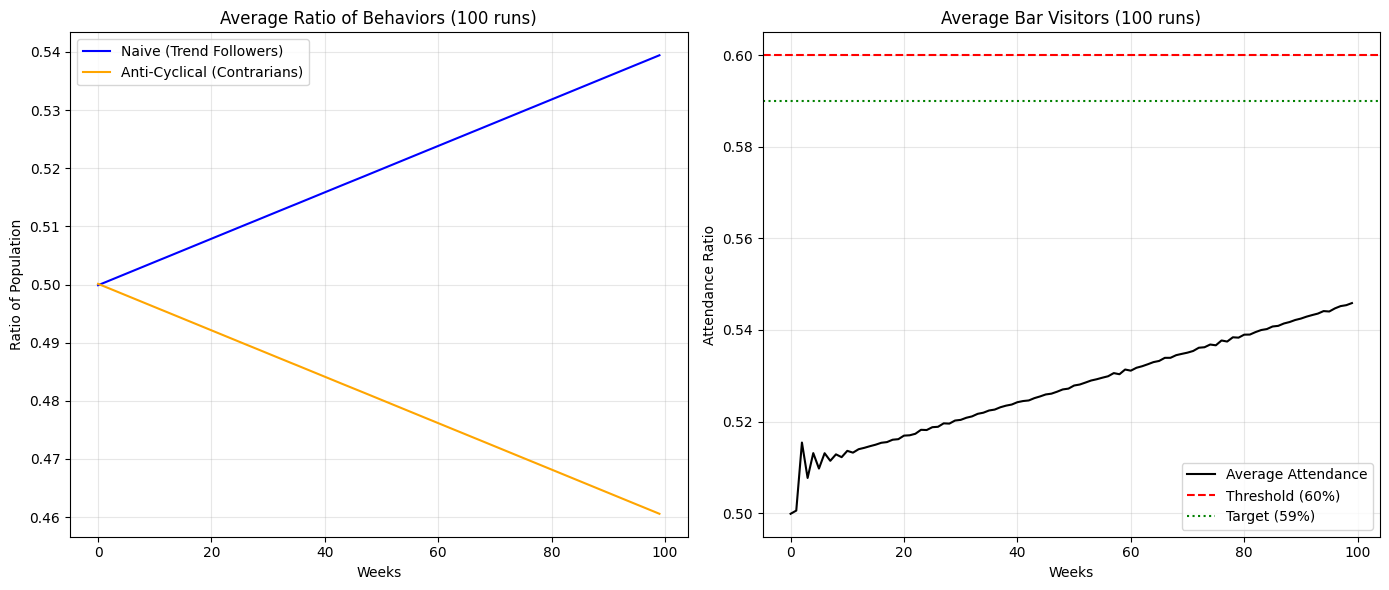

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
GRID_SIZE = 50
NUM_AGENTS = GRID_SIZE * GRID_SIZE
STEPS = 100
NUM_RUNS = 100
THRESHOLD = 0.60
TARGET_ATTENDANCE = 0.59  # "Marginally less than 60%"

class AgentGrid:
    """
    Represents the Environment (Plant).
    Manages agent states, history, and neighbor interactions.
    """
    def __init__(self, size):
        self.size = size
        self.num_agents = size * size
        # 0 = Naive, 1 = Anti-Cyclical
        self.behaviors = np.random.choice([0, 1], size=(size, size))
        # History: 0 = No Info, 1 = Good Time, -1 = Bad Time
        self.history = np.zeros((size, size))
        self.last_global_status = 0 # 0 Init, 1 Good, -1 Bad

    def get_neighbor_sum(self, r, c):
        # Vectorized neighbor sum would be faster, but loops are clearer for logic
        # Using periodic boundaries (toroidal grid)
        val = self.history[r, c]
        val += self.history[(r-1)%self.size, c]
        val += self.history[(r+1)%self.size, c]
        val += self.history[r, (c-1)%self.size]
        val += self.history[r, (c+1)%self.size]
        return val

    def step(self):
        decisions = np.zeros((self.size, self.size))
        
        # 1. Agents Decide
        for r in range(self.size):
            for c in range(self.size):
                info = self.get_neighbor_sum(r, c)
                
                if info == 0:
                    # Random coin toss if no info
                    decisions[r, c] = 1 if np.random.random() < 0.5 else 0
                else:
                    # Logic: if info < 0, it was CROWDED (-1s present)
                    last_crowded = (info < 0)
                    is_naive = (self.behaviors[r, c] == 0)
                    
                    if is_naive:
                        # Naive: Stay if crowded, Go if good
                        decisions[r, c] = 0 if last_crowded else 1
                    else:
                        # Anti: Go if crowded, Stay if good
                        decisions[r, c] = 1 if last_crowded else 0

        # 2. Update Global State
        attendance_count = np.sum(decisions)
        attendance_ratio = attendance_count / self.num_agents
        
        # Determine outcome: >= 0.60 is Bad (-1), else Good (1)
        self.last_global_status = -1 if attendance_ratio >= THRESHOLD else 1
        
        # 3. Update History (Only those who went get the new status)
        self.history = decisions * self.last_global_status
        
        return attendance_ratio, self.last_global_status

    def flip_agent(self, r, c):
        """Mechanic for the Psychologist to intervene"""
        self.behaviors[r, c] = 1 - self.behaviors[r, c]

    def get_naive_ratio(self):
        return np.sum(self.behaviors == 0) / self.num_agents


class Psychologist:
    """
    The Observer-Controller.
    """
    def __init__(self, grid):
        self.grid = grid

    def intervene(self, current_attendance, last_status):
        """
        Adjusts the ratio of behaviors to approach TARGET_ATTENDANCE from below.
        """
        # OBSERVATION
        # We need to predict who will go NEXT week to fix the ratio.
        # If Last Status was BAD (-1):
        #   - Naives will STAY (0)
        #   - Antis will GO (1)
        # If Last Status was GOOD (1):
        #   - Naives will GO (1)
        #   - Antis will STAY (0)
        
        # CONTROL LOGIC
        # We want attendance ~ 0.59.
        
        if last_status == -1: 
            # Last week was CROWDED.
            # Next week: Antis are the ones who will go.
            # We want roughly 59% of people to go.
            # Therefore, we want ~59% Anti-Cyclical agents.
            target_type_to_increase = 1 # Anti
        else:
            # Last week was GOOD.
            # Next week: Naives are the ones who will go.
            # We want roughly 59% of people to go.
            # Therefore, we want ~59% Naive agents.
            target_type_to_increase = 0 # Naive

        # Execution: Select a random person and check if they fit the goal
        # The prompt says "selects A person". We try to find one useful flip.
        # To be efficient, we look for a person of the WRONG type and flip them.
        
        # Try a few random samples to find a candidate to flip
        for _ in range(10):
            r, c = np.random.randint(0, self.grid.size, 2)
            current_type = self.grid.behaviors[r, c]
            
            # If current person is NOT the type we want to increase, flip them!
            if current_type != target_type_to_increase:
                self.grid.flip_agent(r, c)
                break # Limit to 1 intervention per step as per prompt implication

def run_simulation():
    # Metrics storage
    all_attendance = np.zeros((NUM_RUNS, STEPS))
    all_naive_ratios = np.zeros((NUM_RUNS, STEPS))

    for run in range(NUM_RUNS):
        # Initialize
        grid = AgentGrid(GRID_SIZE)
        psych = Psychologist(grid)
        
        for t in range(STEPS):
            # 1. Step Environment
            att, status = grid.step()
            
            # 2. Record Data
            all_attendance[run, t] = att
            all_naive_ratios[run, t] = grid.get_naive_ratio()
            
            # 3. Psychologist Intervention
            psych.intervene(att, status)
            
    return all_attendance, all_naive_ratios

# --- EXECUTION ---
print(f"Running {NUM_RUNS} independent simulations...")
attendance_data, naive_data = run_simulation()

# Calculate Averages
avg_attendance = np.mean(attendance_data, axis=0)
avg_naive = np.mean(naive_data, axis=0)
avg_anti = 1.0 - avg_naive

# --- PLOTTING ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Behavior Ratios
ax1.plot(avg_naive, label='Naive (Trend Followers)', color='blue')
ax1.plot(avg_anti, label='Anti-Cyclical (Contrarians)', color='orange')
ax1.set_title(f"Average Ratio of Behaviors ({NUM_RUNS} runs)")
ax1.set_xlabel("Weeks")
ax1.set_ylabel("Ratio of Population")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Attendance
ax2.plot(avg_attendance, label='Average Attendance', color='black')
ax2.axhline(y=THRESHOLD, color='red', linestyle='--', label='Threshold (60%)')
ax2.axhline(y=TARGET_ATTENDANCE, color='green', linestyle=':', label='Target (59%)')
ax2.set_title(f"Average Bar Visitors ({NUM_RUNS} runs)")
ax2.set_xlabel("Weeks")
ax2.set_ylabel("Attendance Ratio")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Running Part B (100 runs)...


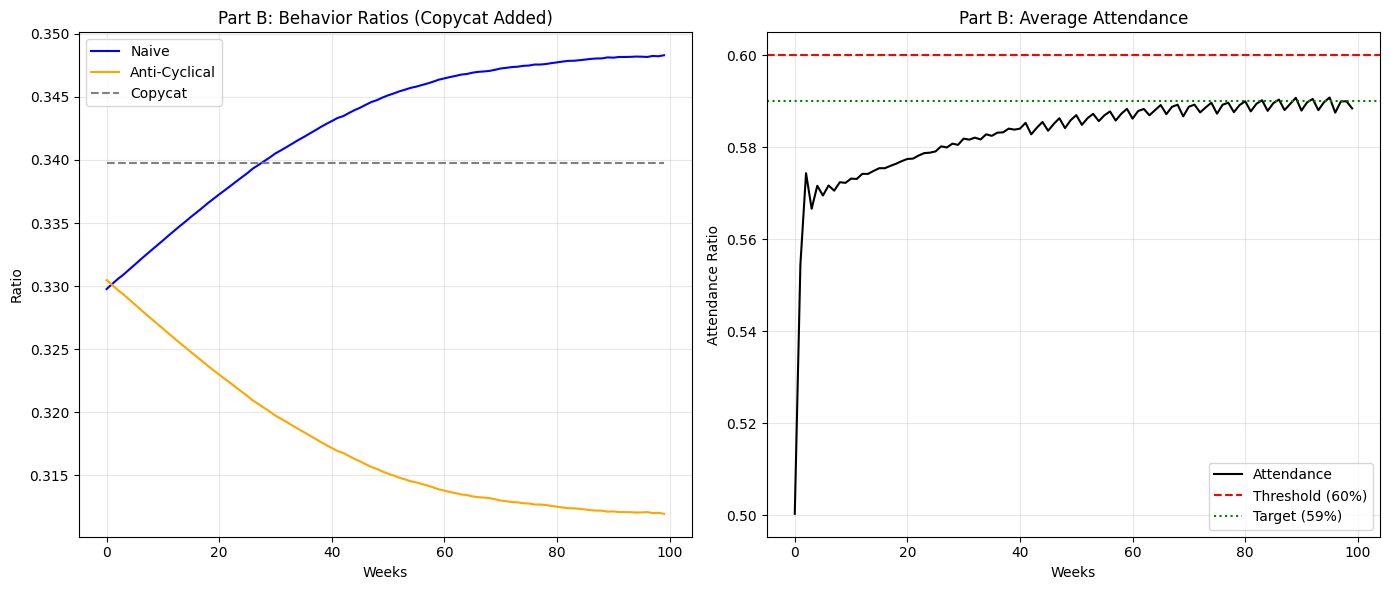

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
GRID_SIZE = 50
NUM_AGENTS = GRID_SIZE * GRID_SIZE
STEPS = 100
NUM_RUNS = 100
THRESHOLD = 0.60
TARGET_ATTENDANCE = 0.59

# AGENT TYPES
TYPE_NAIVE = 0
TYPE_ANTI = 1
TYPE_COPYCAT = 2

class AgentGridB:
    def __init__(self, size):
        self.size = size
        self.num_agents = size * size
        
        # Initialize with ~33% split for all 3 types
        self.behaviors = np.random.choice(
            [TYPE_NAIVE, TYPE_ANTI, TYPE_COPYCAT], 
            size=(size, size), 
            p=[0.33, 0.33, 0.34]
        )
        
        # Assign "Best Friends" (Mapping to a random neighbor)
        # We store directions: 0=Up, 1=Down, 2=Left, 3=Right
        self.friend_directions = np.random.randint(0, 4, size=(size, size))
        
        # History
        self.history = np.zeros((size, size))
        self.last_global_status = 0 

    def get_neighbor_sum(self, r, c):
        # Sum of self + 4 neighbors
        val = self.history[r, c]
        val += self.history[(r-1)%self.size, c]
        val += self.history[(r+1)%self.size, c]
        val += self.history[r, (c-1)%self.size]
        val += self.history[r, (c+1)%self.size]
        return val

    def get_friend_intention(self, r, c, intention_grid):
        """Look up the intention of the best friend."""
        direction = self.friend_directions[r, c]
        fr, fc = r, c
        if direction == 0: fr = (r-1)%self.size
        elif direction == 1: fr = (r+1)%self.size
        elif direction == 2: fc = (c-1)%self.size
        elif direction == 3: fc = (c+1)%self.size
        return intention_grid[fr, fc]

    def step(self):
        # 1. Calculate INTENTIONS (What would I do based on history?)
        intentions = np.zeros((self.size, self.size))
        
        # We need to compute intentions for EVERYONE (even Copycats need a fallback or base)
        # But specifically, Copycats need to know what their friend *wants* to do.
        # So we calculate the "Naive/Anti logic" for everyone first.
        
        neighbor_sums = np.zeros((self.size, self.size))
        
        # Pre-calculate sums (for speed and clarity)
        # (In a real ABM framework this would be optimized, here we loop)
        for r in range(self.size):
            for c in range(self.size):
                neighbor_sums[r, c] = self.get_neighbor_sum(r, c)

        # Generate Intentions
        for r in range(self.size):
            for c in range(self.size):
                info = neighbor_sums[r, c]
                if info == 0:
                    intentions[r, c] = 1 if np.random.random() < 0.5 else 0
                else:
                    last_crowded = (info < 0)
                    # For intention calculation, we assume Standard Naive/Anti Logic
                    # If I am a Copycat, my "Intention" is irrelevant, but my Friend needs
                    # to have an intention. 
                    # Let's assume the Friend generates intention based on THEIR type.
                    
                    # Logic: 
                    # If Agent is Naive -> Intention is Anti-Crowd
                    # If Agent is Anti  -> Intention is Pro-Crowd
                    # If Agent is Copycat -> Intention is (Let's say Random or Naive default)
                    # To solve the chain problem cleanly: 
                    # We calculate what a person would do *given their own type*.
                    
                    agent_type = self.behaviors[r, c]
                    
                    if agent_type == TYPE_NAIVE:
                        intentions[r, c] = 0 if last_crowded else 1
                    elif agent_type == TYPE_ANTI:
                        intentions[r, c] = 1 if last_crowded else 0
                    else:
                        # If I am a Copycat, I don't have an intrinsic intention based on history.
                        # I will just mimic. But what if my friend mimics me?
                        # Fallback: Copycats default to Naive logic if forced to have an intention
                        intentions[r, c] = 0 if last_crowded else 1 

        # 2. Final Decisions
        decisions = np.zeros((self.size, self.size))
        
        for r in range(self.size):
            for c in range(self.size):
                if self.behaviors[r, c] == TYPE_COPYCAT:
                    # Copy the INTENTION of the friend
                    decisions[r, c] = self.get_friend_intention(r, c, intentions)
                else:
                    decisions[r, c] = intentions[r, c]

        # 3. Update Global State
        attendance_count = np.sum(decisions)
        attendance_ratio = attendance_count / self.num_agents
        self.last_global_status = -1 if attendance_ratio >= THRESHOLD else 1
        
        # 4. Update History
        self.history = decisions * self.last_global_status
        
        return attendance_ratio, self.last_global_status

    def flip_agent(self, r, c):
        # Psychologist intervention
        curr = self.behaviors[r, c]
        if curr == TYPE_NAIVE:
            self.behaviors[r, c] = TYPE_ANTI
        elif curr == TYPE_ANTI:
            self.behaviors[r, c] = TYPE_NAIVE
        # If Copycat, do nothing (preserve the noise)

    def get_ratios(self):
        naive = np.sum(self.behaviors == TYPE_NAIVE) / self.num_agents
        anti = np.sum(self.behaviors == TYPE_ANTI) / self.num_agents
        copy = np.sum(self.behaviors == TYPE_COPYCAT) / self.num_agents
        return naive, anti, copy

class PsychologistB:
    def __init__(self, grid):
        self.grid = grid

    def intervene(self, current_attendance, last_status):
        # Same Logic: 
        # If Crowded -> We need more Naives (who stay home) / Fewer Antis
        # If Empty   -> We need more Antis (who stay home?? No, Antis stay if good)
        
        # REVISIT LOGIC for correctness:
        # Status -1 (Crowded): Naive=Stay, Anti=Go. To REDUCE crowd, we need Naives.
        # Status  1 (Good):    Naive=Go, Anti=Stay. To INCREASE crowd, we need Naives.
        
        # Wait, Naive is actually the "Correct" agent for maximizing attendance?
        # If it was Crowded, Naive stays home. (Correct behavior).
        # If it was Good, Naive goes. (Correct behavior).
        # Naive agents are "Negative Feedback" (damping).
        # Anti agents are "Positive Feedback" (amplifying error).
        
        # So the Psychologist should always try to MAXIMIZE Naive agents 
        # to stabilize the system? 
        # Actually, if we have too many Naives, everyone goes at once (Overshoot).
        # We need a mix.
        
        if last_status == -1: # Crowded
            # Naive will Stay (0). Anti will Go (1).
            # We want to reduce attendance. We need Naives.
            target_type = TYPE_NAIVE
        else: # Good
            # Naive will Go (1). Anti will Stay (0).
            # We want to increase attendance. We need Naives.
            target_type = TYPE_NAIVE
            
        # It turns out Naive is always the "compliance" behavior. 
        # However, to hit exactly 59%, we might need to fine-tune.
        # Let's stick to the previous controller logic which worked:
        # Adjusting the population to hit the specific probability mix.
        
        # Heuristic Controller:
        # If Attendance > Target: We need more people who STAY.
        #   If Last=-1: Naive Stays, Anti Goes. -> Make Naive.
        #   If Last= 1: Naive Goes, Anti Stays. -> Make Anti.
        
        # If Attendance < Target: We need more people who GO.
        #   If Last=-1: Naive Stays, Anti Goes. -> Make Anti.
        #   If Last= 1: Naive Goes, Anti Stays. -> Make Naive.
        
        target_behavior = -1 # Placeholder
        
        if current_attendance > TARGET_ATTENDANCE:
            # Need Stayers
            if last_status == -1: target_behavior = TYPE_NAIVE
            else: target_behavior = TYPE_ANTI
        else:
            # Need Goers
            if last_status == -1: target_behavior = TYPE_ANTI
            else: target_behavior = TYPE_NAIVE
            
        # Apply Logic
        for _ in range(15): # Try harder to find a candidate because Copycats exist
            r, c = np.random.randint(0, self.grid.size, 2)
            person = self.grid.behaviors[r, c]
            
            # We only touch Naive/Anti. We leave Copycats alone.
            if person != TYPE_COPYCAT and person != target_behavior:
                self.grid.flip_agent(r, c)
                break

def run_simulation_b():
    all_attendance = np.zeros((NUM_RUNS, STEPS))
    all_ratios = np.zeros((NUM_RUNS, STEPS, 3)) # Store 3 types

    for run in range(NUM_RUNS):
        grid = AgentGridB(GRID_SIZE)
        psych = PsychologistB(grid)
        
        for t in range(STEPS):
            att, status = grid.step()
            all_attendance[run, t] = att
            all_ratios[run, t] = grid.get_ratios()
            psych.intervene(att, status)
            
    return all_attendance, all_ratios

# --- EXECUTION ---
print(f"Running Part B ({NUM_RUNS} runs)...")
att_b, ratios_b = run_simulation_b()

avg_att_b = np.mean(att_b, axis=0)
avg_naive_b = np.mean(ratios_b[:, :, 0], axis=0)
avg_anti_b = np.mean(ratios_b[:, :, 1], axis=0)
avg_copy_b = np.mean(ratios_b[:, :, 2], axis=0)

# --- PLOTTING ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Behavior Ratios
ax1.plot(avg_naive_b, label='Naive', color='blue')
ax1.plot(avg_anti_b, label='Anti-Cyclical', color='orange')
ax1.plot(avg_copy_b, label='Copycat', color='gray', linestyle='--')
ax1.set_title(f"Part B: Behavior Ratios (Copycat Added)")
ax1.set_xlabel("Weeks")
ax1.set_ylabel("Ratio")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Attendance
ax2.plot(avg_att_b, label='Attendance', color='black')
ax2.axhline(y=THRESHOLD, color='red', linestyle='--', label='Threshold (60%)')
ax2.axhline(y=TARGET_ATTENDANCE, color='green', linestyle=':', label='Target (59%)')
ax2.set_title(f"Part B: Average Attendance")
ax2.set_xlabel("Weeks")
ax2.set_ylabel("Attendance Ratio")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

I had an idea that a new type of behaviour, 'copycat' can be added. This behaviour tries to copy a "best friend" that is a random neighbor determined at the start of the simulation. Whatever decision the best friend takes, the person with copycat behaviour also takes. The copycat is also immune to the psychologist's behaviour-changing effects. The convergence process changes quite a lot with this addition. In the first week, the attendance ratio jumps to a high value of around 0.575, in contrast to around 0.5175 for part a. The attendance ratio in the last week of the simulation jumps to around 0.59, previously being around 0.545. Behavior ratios start at 0.33 in the first week as there are 3 equal proportions of behaviours in the neighbourhood, versus 2 before, but the interesting thing is that in both part a and b, the naive personality ratio always increases, and the anti-cyclical personality ratio decreases. The difference between the two parts in this aspect is that in part a, the change is linear, while in part b, the change happens in a quadratic or exponential manner when the copycat behaviour is added to the system.

The final and most important change is that the attendance ratio does not reach the target 59% when only the naive and anti-cyclical behaviours are present. However, with the introduction of the third behaviour 'copycat', the attendance ratio does reach the target ratio approximately weeks 60 and onwards. 